# **CDX Analysis with Apache Spark**


####This notebook is broken up into sections with bite-sized examples for demonstrating Spark functionality for CDX processing. We'll be using the various [RDD](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) operations along with [`lambda` functions](https://docs.python.org/2/tutorial/controlflow.html#lambda-expressions) that are applied at each worker.
 
####This notebook consists of 4 parts:
#### *Part 1*: CDX file format
#### *Part 2*: Sample Analyses on the CDX File
#### *Part 3*: Analyzing CDX File

### **Part 1: CDX file format**
####The CDX files that we use are in the [SURT form](https://webarchive.jira.com/wiki/display/Iresearch/SURT+Sorted+CDX+fields). 

### **(1a) Parsing Each CDX Line**
#### If the CDX line fails to match the format, the function returns a pair consisting of the line string and 0.  A '-' value in the content size field is cleaned up by substituting it with 0. The function converts the CDX line's date string into a Python `datetime` object using the given `parse_cdx_time` function.

In [1]:
import re
import datetime

from pyspark.sql import Row

def parse_cdx_time(s):
    """ Convert CDX time format into a Python datetime object
    Args:
        s (str): date and time in CDX time format
    Returns:
        datetime: datetime object
    """
    if not s and len(s) != 14:
        return None
    return datetime.datetime(int(s[0:4]),
                             int(s[4:6]),
                             int(s[6:8]),
                             int(s[8:10]),
                             int(s[10:12]),
                             int(s[12:14]))

def parse_cdx_line(cdx_line):
    """ Parse a CDX line
    Args:
        cdx_line (str): a line of text in the CDX format
    Returns:
        tuple: either a dictionary containing the parts of the CDX line and 1,
               or the original invalid CDX line and 0
    """
    cdx_parts = cdx_line.split()
    if len(cdx_parts) != 11:
        return (cdx_line, 0)
    if cdx_parts[0] == "":
        return (cdx_line, 0)
    date_time = parse_cdx_time(cdx_parts[1])
    if date_time is None:
        return (cdx_line, 0)
    size_field = cdx_parts[8]
    if size_field == '-':
        size = int(0)
    else:
        size = int(size_field)
    return (Row(
        surt_url        = cdx_parts[0],
        timestamp       = date_time,
        orig_url        = cdx_parts[2],
        mime            = cdx_parts[3],
        response_code   = cdx_parts[4],
        digest          = cdx_parts[5],
        redirect_url    = cdx_parts[6],
        meta_tags       = cdx_parts[7],
        compressed_size = size,
        file_offset     = cdx_parts[9],
        file_name       = cdx_parts[10]
    ), 1)


### **(1b) Configuration and Initial RDD Creation**
####We are ready to specify the input CDX file and create an RDD containing the parsed CDX file data. 
 
####To create the primary RDD that we'll use, we first load the text file using [`sc.textfile(cdx_data)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext.textFile) to convert each line of the file into an element in an RDD.
####Next, we use [`map(parse_cdx_line)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.map) to apply the parse function to each element (that is, a line from the CDX file) in the RDD and turn each line into a pair [`Row` object](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Row).
####Finally, we cache the RDD in memory since we'll use it throughout this notebook.

In [2]:
import sys
import os

cdx_data = '/search/ait/ferguson-combined/cdx/FERGYTV*cdx.gz'
num_partitions = 40

def parse_cdx_data():
    """ Read and parse CDX files """
    parsed_cdx     = (sc
                      .textFile(cdx_data)
                      .map(parse_cdx_line)
                      .repartition(num_partitions)
                      .cache())

    cdx            = (parsed_cdx
                      .filter(lambda s: s[1] == 1)
                      .map(lambda s: s[0])
                      .cache())

    ignored_cdx    = (parsed_cdx
                      .filter(lambda s: s[1] == 0)
                      .map(lambda s: s[0]))

    ignored_cdx_count = ignored_cdx.count()
    if ignored_cdx_count > 0:
        print('Number of ignored CDX Lines: %d' % ignored_cdx_count)
        for line in ignored_cdx.take(20):
            print('Ignored CDX Line: %s' % line)

    print('Read: %d lines, Valid: %d lines, Ignored: %d lines' % (parsed_cdx.count(), cdx.count(), ignored_cdx.count()))
    return parsed_cdx, cdx, ignored_cdx

parsed_cdx, cdx, ignored_cdx = parse_cdx_data()
parsed_cdx.unpersist()


Number of ignored CDX Lines: 1546
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Ignored CDX Line:  CDX N b a m s k r M S V g
Read: 201289 lines, Valid: 199743 lines, Ignored: 1546 lines


MapPartitionsRDD[6] at repartition at NativeMethodAccessorImpl.java:-2

### **Part 2: Sample Analyses on the CDX File**
 
####Now that we have an RDD containing the CDX file as a set of Row objects, we can perform various analyses.
 
#### **(2a) Example: Content Size Statistics**
 
####Let's compute some statistics about the sizes of content crawled. In particular, we'd like to know what are the average, minimum, and maximum content sizes.
 
####We can compute the statistics by applying a `map` to the `cdx` RDD. The `lambda` function we want for the map is to extract the `compressed_size` field from the RDD. The map produces a new RDD containing only the `compressed_sizes` (one element for each Row object in the `cdx` RDD). To compute the minimum and maximum statistics, we can use [`min()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.min) and [`max()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.max) functions on the new RDD. We can compute the average statistic by using the [`reduce`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduce) function with a `lambda` function that sums the two inputs, which represent two elements from the new RDD that are being reduced together. The result of the `reduce()` is the total content size from the log and it is to be divided by the number of requests as determined using the [`count()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count) function on the new RDD.

In [3]:
# Calculate statistics based on the content size.
content_sizes = cdx.map(lambda line: line.compressed_size).cache()
print('Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max()))

Content Size Avg: 9602349, Min: 632, Max: 1991664798


#### **(2b) Example: Response Code Analysis**
####Next, lets look at the response codes that appear in the CDX. As with the content size analysis, first we create a new RDD by using a `lambda` function to extract the `response_code` field from the `cdx` RDD. The difference here is that we will use a [pair tuple](https://docs.python.org/2/tutorial/datastructures.html?highlight=tuple#tuples-and-sequences) instead of just the field itself. Using a pair tuple consisting of the response code and 1 will let us count how many records have a particular response code. Using the new RDD, we perform a [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) function. `reduceByKey` performs a reduce on a per-key basis by applying the `lambda` function to each element, pairwise with the same key. We use the simple `lambda` function of adding the two values. Then, we cache the resulting RDD and create a list by using the [`take`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) function.

In [4]:
def getTopLevelResponseCode(response_code):
    top_level_response_code = response_code[0]
    if top_level_response_code not in ['2', '3', '4', '5']:
        top_level_response_code = '-'
    return top_level_response_code

# Response Code to Count
responseCodeToCount = (cdx
                       .map(lambda line: (getTopLevelResponseCode(line.response_code), 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print('Found %d response codes' % len(responseCodeToCountList))
print('Response Code Counts: %s' % responseCodeToCountList)


Found 2 response codes
Response Code Counts: [('2', 178943), ('3', 20800)]


#### **(2c) Example: Response Code Graphing with `matplotlib`**
####Now, lets visualize the results from the last example. We can visualize the results from the last example using [`matplotlib`](http://matplotlib.org/). First we need to extract the labels and fractions for the graph. We do this with two separate `map` functions with a `lambda` functions. The first `map` function extracts a list of of the response code values, and the second `map` function extracts a list of the per response code counts  divided by the total size of the CDX lines. Next, we create a figure with `figure()` constructor and use the `pie()` method to create the pie plot.

In [5]:
labels = responseCodeToCount.map(lambda x: x[0]).collect()
print(labels)
count = cdx.count()
fracs = responseCodeToCount.map(lambda x: (float(x[1]) / count)).collect()
print(fracs)

['2', '3']
[0.8958661880516464, 0.10413381194835364]


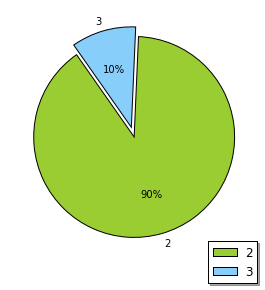

In [7]:
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
#colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral']
#explode = (0.05, 0.05, 0.1, 0, 0)
colors = ['yellowgreen', 'lightskyblue']
explode = (0.05, 0.05)


#colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black', 'red']
#explode = (0.05, 0.05, 0.1, 0, 0, 0, 0, 0)

patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

#### **(2d) Example: Frequent Hosts**
####Let's look at hosts that have been crawled multiple times (e.g., more than ten times). As with the response code analysis in (2b), first we create a new RDD by using a `lambda` function to extract the `host` field (using `url` field) from the `cdx` RDD using a pair tuple consisting of the host and 1 which will let us count how many records per host. Using the new RDD, we perform a `reduceByKey` function with a `lambda` function that adds the two values. 

In [8]:
def getHostFromSurtUrl(surtUrl):
   host = None
   if not surtUrl:
      return None
   surtUrlParts = surtUrl.split('/')
   surtHost = surtUrlParts[0]
   #strip away any text after whitespace
   surtHostParts = surtHost.split()
   if len(surtHostParts) == 0:
      return None
   surtHost = surtHostParts[0]
   #strip away port number
   surtHostParts = surtHost.split(':')
   surtHost = surtHostParts[0]
   surtHost = surtHost.replace(")","")
   surtHostParts = surtHost.split(',')
   surtHostParts.reverse()
   host = '.'.join(surtHostParts)
   return host

hostCountPairTuple = cdx.map(lambda line: (getHostFromSurtUrl(line.surt_url), 1))
hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)
hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)
hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print('Any 20 hosts that have been crawled more then 10 times: %s' % hostsPick20)
# An example: [u'204.120.34.185', u'204.243.249.9', u'slip1-32.acs.ohio-state.edu', u'lapdog-14.baylor.edu', u'199.77.67.3', u'gs1.cs.ttu.edu', u'haskell.limbex.com', u'alfred.uib.no', u'146.129.66.31', u'manaus.bologna.maraut.it', u'dialup98-110.swipnet.se', u'slip-ppp02.feldspar.com', u'ad03-053.compuserve.com', u'srawlin.opsys.nwa.com', u'199.202.200.52', u'ix-den7-23.ix.netcom.com', u'151.99.247.114', u'w20-575-104.mit.edu', u'205.25.227.20', u'ns.rmc.com']

Any 20 hosts that have been crawled more then 10 times: ['r6---sn-a5m7zu7l.googlevideo.com', 'r15---sn-nwj7kner.googlevideo.com', 'r8---sn-a5m7zu7s.googlevideo.com', 'r8---sn-a5m7zu7k.googlevideo.com', 'r16---sn-nwj7kner.googlevideo.com', 'r19---sn-nwj7knl7.googlevideo.com', 'r18---sn-o097znle.googlevideo.com', 'r2---sn-nwj7knls.googlevideo.com', 'r5---sn-nwj7knl7.googlevideo.com', 'r5---sn-a5m7zu76.googlevideo.com', 'r18---sn-nwj7knl7.googlevideo.com', 'r15---sn-nwj7knek.googlevideo.com', 'r7---sn-o097znle.googlevideo.com', 'r13---sn-nwj7kne6.googlevideo.com', 'r4---sn-nwj7kned.googlevideo.com', 'r17---sn-nwj7knls.googlevideo.com', 'r1---sn-a5m7zu76.googlevideo.com', 'r3---sn-o097znle.googlevideo.com', 'r2---sn-nwj7kned.googlevideo.com', 'r16---sn-nwj7knek.googlevideo.com']


#### **(2e) Example: Top MIME types**
####For the final example, we'll look at the top MIME types in the CDX. To determine them, we first create a new RDD by using a `lambda` function to extract the `mime` field from the `cdx` RDD using a pair tuple consisting of the MIME and 1 which will let us count how many records were crawled per MIME. Using the new RDD, we perform a `reduceByKey` function with a `lambda` function that adds the two values. We then extract the top ten MIME by performing a [`takeOrdered`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.takeOrdered) with a value of 3 and a `lambda` function that multiplies the count (the second element of each pair) by -1 to create a sorted list with the top MIME types at the bottom.

In [9]:
mimeCounts = (cdx
              .map(lambda line: (line.mime, 1))
              .reduceByKey(lambda a, b : a + b))
topMimes = mimeCounts.takeOrdered(3, lambda s: -1 * s[1])
print('Top Three MIME: %s' % topMimes)


Top Three MIME: [('image/jpeg', 63275), ('text/html', 55927), ('application/x-www-form-urlencoded', 35126)]


### **Part 3: Analyzing CDX File**


#### **(3a) Exercise: Top Ten Error Hosts**
####What are the top ten hosts which returned a 404? Create a sorted list containing top ten hosts and the number of times that they were crawled with 404 response code.

In [10]:
errors404 = cdx.filter(lambda line: line.response_code == '404')
hostCountPairTuple = errors404.map(lambda line: (getHostFromSurtUrl(line.surt_url), 1))
hostSum = hostCountPairTuple.reduceByKey(lambda a,b: a + b)
topTenErrHosts = hostSum.takeOrdered(10, lambda s: -1 * s[1])
print('Top Ten error Hosts: %s' % topTenErrHosts)

Top Ten error Hosts: []


#### **(3b) Exercise: Number of Unique Hosts**
####How many unique hosts are there in the entire CDX?

In [11]:
hosts = cdx.map(lambda line: (getHostFromSurtUrl(line.surt_url), 1))
uniqueHosts = hosts.reduceByKey(lambda a,b: a + b)
uniqueHostCount = uniqueHosts.count()
print('Unique hosts: %d' % uniqueHostCount)

Unique hosts: 255


#### **(3c) Exercise: Number of Unique Daily Hosts**
####Let's determine the number of unique hosts in the entire CDX on a day-by-day basis. This computation will give us counts of the number of unique daily hosts. We'd like a list sorted by increasing day of year and the associated number of unique hosts for that day. Make sure you cache the resulting RDD `dailyHosts` so that we can reuse it in the next exercise.

In [12]:
dayToHostPairTuple = cdx.map(lambda line: (line.timestamp.timetuple().tm_yday, getHostFromSurtUrl(line.surt_url)))
dayGroupedHosts = dayToHostPairTuple.distinct()
dayHostCount = dayGroupedHosts.groupByKey()
dailyHosts = dayHostCount.map(lambda kv: (kv[0], len(kv[1]))).sortByKey().cache()
dailyHostsList = dailyHosts.take(30)
print('Unique hosts per day: %s' % dailyHostsList)

Unique hosts per day: [(37, 227), (38, 234), (39, 240), (40, 233)]


#### Exercise: Visualizing the Number of Unique Daily Hosts**
####Using the results from the previous exercise, use `matplotlib` to plot a "Line" graph of the unique hosts requests by day.
#### `daysWithHosts` should be a list of days and `hosts` should be a list of number of unique hosts for each corresponding day.
#### * How could you convert a RDD into a list? See the [`collect()` method](http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=collect#pyspark.RDD.collect)*

In [13]:
daysWithHosts = dailyHosts.map(lambda x: x[0]).collect()
hosts = dailyHosts.map(lambda x: x[1]).collect()

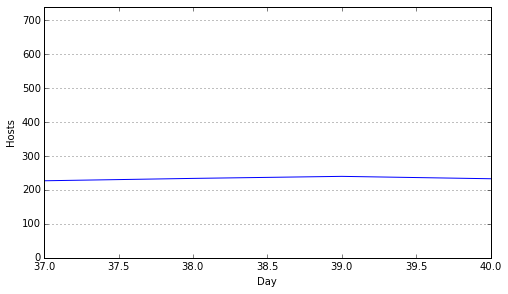

In [14]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)
pass

#### **(3e) Exercise: Average Number of Daily captures crawled per Host**
####Next, let's determine the average number of crawled URLs on a day-by-day basis. We'd like a list by increasing day of the month and the associated average number of crawled URLs per host for that day. Make sure you cache the resulting RDD `avgDailyCapturesPerHost` so that we can reuse it in the next exercise.
####To compute the average number of captures per host, get the total number of captures across all hosts and divide that by the number of unique hosts.

In [15]:
dayAndHostTuple = cdx.map(lambda line: (line.timestamp.timetuple().tm_yday, getHostFromSurtUrl(line.surt_url)))
groupedByDay = dayAndHostTuple.groupByKey()
sortedByDay = groupedByDay.sortByKey()
avgDailyCapturesPerHost = (sortedByDay
                           .map(lambda x: (x[0], len(x[1]) / len(list(set(x[1])))))).cache()
avgDailyCapturesPerHostList = avgDailyCapturesPerHost.take(30)
print('Average number of daily captures per Host is %s' % avgDailyCapturesPerHostList)

Average number of daily captures per Host is [(37, 66.6784140969163), (38, 298.87179487179486), (39, 291.6875), (40, 191.69957081545064)]


#### **(3f) Exercise: Visualizing the Average Daily Captures per Unique Host**
####Using the result `avgDailyCapturesPerHost` from the previous exercise, use `matplotlib` to plot a "Line" graph of the average daily captures per unique host by day.
#### `daysWithAvg` should be a list of days and `avgs` should be a list of average daily captures per unique host for each corresponding day.

In [16]:
daysWithAvg = avgDailyCapturesPerHost.map(lambda kv: kv[0]).collect()
avgs = avgDailyCapturesPerHost.map(lambda kv: kv[1]).collect()

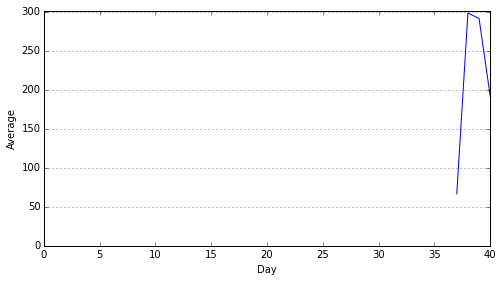

In [17]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)
pass